###  Zhao, Morrison, Parr Inversion Method:

In [4]:
import n2v
from pyscf import gto
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
mpl.rcParams["font.size"] = 11
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.edgecolor"] = "#eae8e9" 

In [5]:
# Define Molecule
Ne = gto.M(atom = """
                  Ne
                  """,
basis = 'aug-cc-pvtz')

# Perform Calculation
mf = Ne.KS()
mf.xc = 'scan'
mf.kernel()

# Extract data for n2v. 
da, db = mf.make_rdm1()/2, mf.make_rdm1()/2
ca, cb = mf.mo_coeff[:,:Ne.nelec[0]], mf.mo_coeff[:, :Ne.nelec[1]]
ea, eb = mf.mo_energy, mf.mo_energy

# Initialize inverter object. 
ine = n2v.Inverter( engine='pyscf' )

ine.set_system( Ne, 'aug-cc-pvtz' )
ine.Dt = [da, db]
ine.ct = [ca, cb]
ine.et = [ea, eb]

converged SCF energy = -128.935779461056
converged SCF energy = -128.218458514745  <S^2> = -1.7763568e-15  2S+1 = 1


 Let us now invert the density using the [Zhao, Morrison, Parr Method](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.50.2138):

---
##### The Zhao, Morrison, Parr method works by updating self-consistently a potential generated by the difference in density. 
The driving potential at step $i$ is:

$$v_c^i(r) = \lambda \int \frac{n_i(r') - n_{0}(r')}{|r-r'|} dr'$$

where $n(r)$ is the current density iteration and $n_0(r)$ is the target density that remains fixed during the scf procedure.

The $\lambda$ parameter is a Lagrange multiplier that in the limit of $\lambda \rightarrow \infty$, allows $v_c$ to become the exact potential. In practice we won't be able to increase lambda arbitrarily but values like $25$, $50$ or $75$ are commonly used. An iterative approach also lets you perform an extrapolation technique iteratively. In order to trigger this calculation, specify more than one lambda. A reliable option to choose is to begin with $\lambda=10$ and make enough iterations to achieve desired convergence in density. 

The algorithm will need an initial potential components to guide the inversion procedure. It is common to use the "Fermi Amaldi" (FA) Potential. Let us now use all of the previous information to perform the desired inversions. 

---
##### The potential that we are looking for is driven by density difference. The potential is then added to the Fock matrix as Hartree contribution. 
##### Thus if we want to visualize the potential, we need to compute the Hartree of a combination of the obtained density and the target density according to:

$$
v_{xc}(r) = v_c(r) - (1-1/N) \cdot v_{FA}(r)
$$

In practice, the result from the scf calculation is stored in:
```
inverter.proto_density_a
inverter.proto_density_b
```
We need to provide this information to the Hartree generating function. This function uses the density stored in the initial wfn object. Thus we need to overwrite this quantity. (Be careful, this is a destructive action that will permanently remove the density within the wfn object).

##### Finally we plot as if we were trying to extract the Hartree potential according $v_c(r)$ above.

In [14]:
# Let us define a plotting grid:

npoints=1001
x = np.linspace(-5,5,npoints)[:,None]
y = np.zeros_like(x)
z = y
grid = np.concatenate((x,y,z), axis=1)

ine.eng.grid.rectangular_grid = grid

Let's do ZMP calculation. Let's first try **zmp_mixing=1**, which means that all the potentials of previous lambdas are accumulated, the larger lambda potential are meant to fix the wrong/inaccurate region of the potential of the sum of the previous potentials instead of providing an entire new potentials:
$$v_c^i(r) = v_c^{i-1}(r) + \Delta v_i = \sum_{j\leq i} \lambda_j \int \frac{n_j(r') - n_{0}(r')}{|r-r'|} dr'.$$

In [8]:
ine.invert("zmp", opt_max_iter=200, opt_tol=1e-7, zmp_mixing=1, 
           lambda_list=np.linspace(10, 1000, 20), guide_components="fermi_amaldi")


Running ZMP:
SCF Converged for lambda:   10. Max density difference: 7.428721340990421
SCF Converged for lambda:   62. Max density difference: 1.6497161704022005
SCF Converged for lambda:  114. Max density difference: 0.24683359276207284
SCF Converged for lambda:  166. Max density difference: 0.03898450340847148
SCF Converged for lambda:  218. Max density difference: 0.011836550878513208
SCF Converged for lambda:  270. Max density difference: 0.005203340601497075
SCF Converged for lambda:  322. Max density difference: 0.001648680803583602
SCF Converged for lambda:  374. Max density difference: 0.0008520993137608457

ZMP halted at lambda=426.8421052631579. Density Error Stops Updating: old: 0.0008520993137608457, current: 0.0024674307811096696.


(-5.0, 5.0)

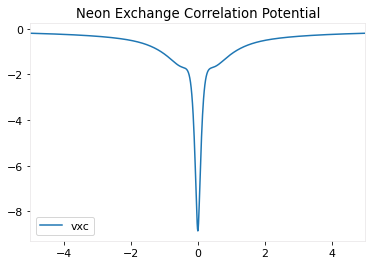

In [15]:
vxc_ne = ine.eng.grid.hartree(density=ine.proto_density_a+ine.proto_density_b, grid='rectangular' )

fig, ax = plt.subplots()
ax.plot(x,  vxc_ne, label="vxc")
ax.set_title("Neon Exchange Correlation Potential")

ax.legend()
ax.set_xlim(-5,5)

Let's modify the **zmp_mixing=0.5**: $$v_c^i(r) = \textrm{zmp_mixing} \times v_c^{i-1}(r) + \Delta v_i.$$

In [17]:
ine.invert("zmp", opt_max_iter=200, opt_tol=1e-7, zmp_mixing=0.5, 
           lambda_list=np.linspace(10, 1000, 20), guide_components="fermi_amaldi")


Running ZMP:
SCF Converged for lambda:   10. Max density difference: 7.428721340990421
SCF Converged for lambda:   62. Max density difference: 2.1159977808096073
SCF Converged for lambda:  114. Max density difference: 0.800880481247475
SCF Converged for lambda:  166. Max density difference: 0.3372309333360022
SCF Converged for lambda:  218. Max density difference: 0.15151478075699742
SCF Converged for lambda:  270. Max density difference: 0.07144777321536822
SCF Converged for lambda:  322. Max density difference: 0.03491056003036874
SCF Converged for lambda:  374. Max density difference: 0.01730241653228859
SCF Converged for lambda:  426. Max density difference: 0.008301278526687383
SCF Converged for lambda:  478. Max density difference: 0.0033902348512242497
SCF Converged for lambda:  531. Max density difference: 0.0010974274530894945

ZMP halted at lambda=583.1578947368421. Density Error Stops Updating: old: 0.0010974274530894945, current: 0.001260090564244365.


(-5.0, 5.0)

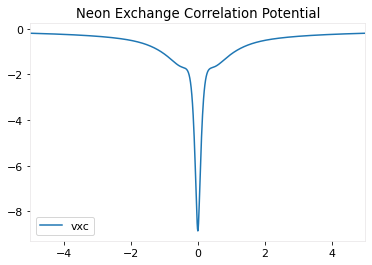

In [18]:
vxc_ne1 = ine.eng.grid.hartree(density=ine.proto_density_a+ine.proto_density_b, grid='rectangular' )


fig, ax = plt.subplots()
ax.plot(x,  vxc_ne1, label="vxc")
ax.set_title("Neon Exchange Correlation Potential")

ax.legend()
ax.set_xlim(-5,5)

Or **zmp_mixing=0**, which make only the last lambda will contribute to the resulting potential at each scf step.

In [19]:
ine.invert("zmp", opt_max_iter=200, opt_tol=1e-7, zmp_mixing=0, 
           lambda_list=np.linspace(10, 1000, 20), guide_components="fermi_amaldi")


Running ZMP:
SCF Converged for lambda:   10. Max density difference: 7.428721340990421
SCF Converged for lambda:   62. Max density difference: 2.58211317846434
SCF Converged for lambda:  114. Max density difference: 1.5743638698282894
SCF Converged for lambda:  166. Max density difference: 1.1351054814239774
SCF Converged for lambda:  218. Max density difference: 0.8885610676389888
SCF Converged for lambda:  270. Max density difference: 0.7305010569763795
SCF Converged for lambda:  322. Max density difference: 0.6204279740228458
SCF Converged for lambda:  374. Max density difference: 0.5393073447963843
SCF Converged for lambda:  426. Max density difference: 0.47700761526346014
SCF Converged for lambda:  478. Max density difference: 0.4276365391530703
SCF Converged for lambda:  531. Max density difference: 0.387532649888783
SCF Converged for lambda:  583. Max density difference: 0.3543003249941421
SCF Converged for lambda:  635. Max density difference: 0.3263055075912007
SCF Converged 

(-5.0, 5.0)

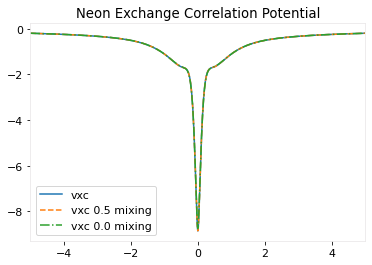

In [20]:
vxc_ne2 = ine.eng.grid.hartree(density=ine.proto_density_a+ine.proto_density_b, grid='rectangular' )

plt.plot(x,  vxc_ne, label="vxc")
plt.plot(x,  vxc_ne1, label="vxc 0.5 mixing", ls="--")
plt.plot(x,  vxc_ne2, label="vxc 0.0 mixing", ls="-.")
plt.title("Neon Exchange Correlation Potential")

plt.legend()
plt.xlim(-5,5)
# plt.ylim(-10,1)

In [48]:
inv.invert("zmp", opt_max_iter=200, opt_tol=1e-7, zmp_mixing=0.1, 
           lambda_list=np.linspace(10, 1000, 20), guide_components="fermi_amaldi")


Running ZMP:
SCF Converged for lambda:   10. Max density difference: 15.831574851366554
SCF Converged for lambda:   62. Max density difference: 5.138565712548029
SCF Converged for lambda:  114. Max density difference: 2.782053183663834
SCF Converged for lambda:  166. Max density difference: 1.7541251216251794
SCF Converged for lambda:  218. Max density difference: 1.1872799522550395
SCF Converged for lambda:  270. Max density difference: 0.8344483719836262
SCF Converged for lambda:  322. Max density difference: 0.5980863696522647
SCF Converged for lambda:  374. Max density difference: 0.4318423101598228
SCF Converged for lambda:  426. Max density difference: 0.3108522768387729
SCF Converged for lambda:  478. Max density difference: 0.22058362827056044
SCF Converged for lambda:  531. Max density difference: 0.15198097652955767
SCF Converged for lambda:  583. Max density difference: 0.09911505921229491
SCF Converged for lambda:  635. Max density difference: 0.061361673759734
SCF Converg

In [21]:
vxc_ne3 = ine.eng.grid.hartree(density=ine.proto_density_a+ine.proto_density_b, grid='rectangular' )


(-5.0, 5.0)

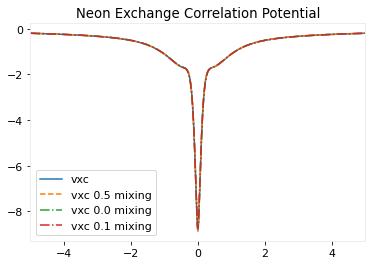

In [22]:
plt.plot(x,  vxc_ne, label="vxc")
plt.plot(x,  vxc_ne1, label="vxc 0.5 mixing", ls="--")
plt.plot(x,  vxc_ne2, label="vxc 0.0 mixing", ls="-.")
plt.plot(x,  vxc_ne3, label="vxc 0.1 mixing", ls="-.")
plt.title("Neon Exchange Correlation Potential")

plt.legend()
plt.xlim(-5,5)


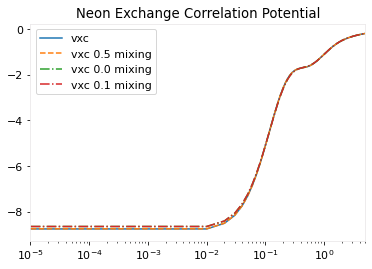

In [23]:
fig, ax = plt.subplots()
ax.plot(x,  vxc_ne, label="vxc")
ax.plot(x,  vxc_ne1, label="vxc 0.5 mixing", ls="--")
ax.plot(x,  vxc_ne2, label="vxc 0.0 mixing", ls="-.")
ax.plot(x,  vxc_ne3, label="vxc 0.1 mixing", ls="-.")
ax.set_title("Neon Exchange Correlation Potential")

ax.legend()
ax.set_xlim(1e-5,5)
ax.set_xscale("log")